<a href="https://colab.research.google.com/github/AbhayPancholi/AbhayPancholi/blob/main/project_weed_segmentation_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imported libraries

In [ ]:


from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os




In [ ]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate,UpSampling2D
from tensorflow.keras.optimizers import Adam

## Define directories for original images and masks

In [ ]:
# Define directories for original images and masks
original_dir ="/content/drive/MyDrive/weed dataset/original images of weeds"
mask_dir = "/content/drive/MyDrive/weed dataset/mask images of weeds/project-3-at-2024-04-13-19-15-fd82b9e2"


# Get list of file names in both directories

In [ ]:
# Get list of file names in both directories
original_files = os.listdir(original_dir)
mask_files = os.listdir(mask_dir)
print(
    f"Number of original images: {len(original_files)}"
)
print(f"Number of mask images: {len(mask_files)}")

Number of original images: 395
Number of mask images: 395


# Sort files to ensure correspondence between original and mask images

In [ ]:
# Sort files to ensure correspondence between original and mask images
original_files.sort()
mask_files.sort()


# Initialize lists to store original and mask images

In [ ]:
# Initialize lists to store original and mask images
original_images = []
mask_images = []

# Load original and mask images

In [ ]:
# Load original and mask images
for original_file, mask_file in zip(original_files, mask_files):
    original_path = os.path.join(original_dir, original_file)
    mask_path = os.path.join(mask_dir, mask_file)

    original_img = Image.open(original_path)
    mask_img = Image.open(mask_path)

    # Resize images if needed
    original_img = original_img.resize((256, 256))  # Adjust size as necessary
    mask_img = mask_img.resize((256, 256))  # Adjust size to match original image

    # Convert images to numpy arrays and normalize pixel values
    original_array = np.array(original_img) / 255.0
    mask_array = np.array(mask_img) / 255.0

    original_images.append(original_array)
    mask_images.append(mask_array)


# Convert lists to numpy arrays

In [ ]:
# Convert lists to numpy arrays
original_images = np.array(original_images)
mask_images = np.array(mask_images)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(original_images, mask_images, test_size=0.2, random_state=42)

# Print shapes of training and testing sets
print("Training set shapes:")
print("Original images:", x_train.shape)
print("Mask images:", y_train.shape)
print("Testing set shapes:")
print("Original images:", x_test.shape)
print("Mask images:", y_test.shape)


Training set shapes:
Original images: (316, 256, 256, 3)
Mask images: (316, 256, 256)
Testing set shapes:
Original images: (79, 256, 256, 3)
Mask images: (79, 256, 256)


# defined the model architecture


In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model



# initialize the model

In [ ]:
model = unet()

# compile the model

In [ ]:
import tensorflow as tf

In [ ]:
model.compile(optimizer='Adam', loss=dice_loss, metrics=[dice_coefficient])


In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# trained the model

In [ ]:
 #Train the model
model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
20/20 [==============================] - 1947s 97s/step - loss: 0.4567 - dice_coefficient: 0.5433 - val_loss: 0.4790 - val_dice_coefficient: 0.5203
Epoch 2/10
20/20 [==============================] - 1936s 97s/step - loss: 0.4471 - dice_coefficient: 0.5529 - val_loss: 0.4790 - val_dice_coefficient: 0.5203
Epoch 3/10
16/20 [=======================>......] - ETA: 6:03 - loss: 0.4545 - dice_coefficient: 0.5455

# Evaluate the model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

3/3 [==============================] - 17s 357ms/step - loss: 0.4619 - dice_coefficient: 0.5454
Test Loss: 0.4619101881980896
Test Accuracy: 0.54535311460495


In [ ]:
model.save("weed segmentation.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
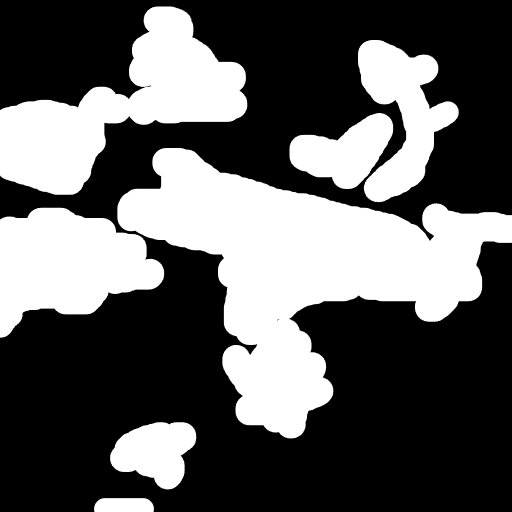

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define custom dice coefficient and dice loss functions
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Load your trained model with the custom loss and metric functions
MODEL_PATH = '/content/weed segmentation.h5'
model = load_model(MODEL_PATH, custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

# Evaluate the model on the test set
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

# Predict the mask for a single image
def predict_mask(model, img):
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    prediction = (prediction > 0.5).astype(np.uint8)  # Binarize the output
    return prediction[0]

# Display the original image, ground truth mask, and predicted mask
def display_images(original_img, ground_truth_mask, predicted_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')

    plt.show()

if __name__ == "__main__":
    # Assuming x_test and y_test are already loaded and available in the environment
    # x_test and y_test should be numpy arrays with appropriate shapes

    # Evaluate the model
    evaluate_model(model, x_test, y_test)

    # Predict the mask for a sample image
    sample_idx = 0  # You can change this index to visualize different samples
    original_img = x_test[sample_idx]
    ground_truth_mask = y_test[sample_idx]
    predicted_mask = predict_mask(model, original_img)

    # Display the results
    display_images(original_img, ground_truth_mask, predicted_mask)


array([[[ 97, 133, 139],
        [ 95, 146, 149],
        [ 73, 150, 147],
        ...,
        [ 30, 102,  50],
        [ 32, 101,  50],
        [ 31, 100,  49]],

       [[109, 147, 151],
        [110, 162, 162],
        [ 85, 162, 158],
        ...,
        [ 24,  96,  44],
        [ 28, 100,  48],
        [ 31, 103,  51]],

       [[ 46,  93,  90],
        [ 48, 105,  97],
        [ 27, 103,  92],
        ...,
        [ 48, 123,  69],
        [ 52, 127,  73],
        [ 56, 131,  77]],

       ...,

       [[  9,  34,  20],
        [  4,  31,  15],
        [  0,  28,  11],
        ...,
        [ 30,  85,  30],
        [ 31,  86,  31],
        [ 35,  90,  35]],

       [[ 20,  42,  30],
        [ 15,  40,  26],
        [  9,  38,  23],
        ...,
        [ 55, 112,  57],
        [ 54, 111,  56],
        [ 54, 111,  56]],

       [[ 46,  68,  56],
        [ 45,  69,  57],
        [ 42,  71,  56],
        ...,
        [ 81, 139,  84],
        [ 80, 137,  82],
        [ 77, 134,  79]]], dtype=uint8)
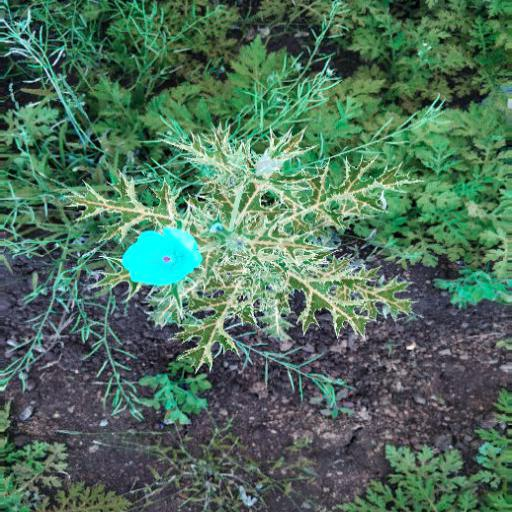